# Music Generation using Wavenet  

Importing the prerequisite libraries

In [1]:
import numpy as np 
import pandas as pd 

Music 21 is a library or toolkit used for manipulation of midi files. A midi file consists of notes, chords, pitch, octave and offset. In our dataset, the offset is constant.We load each file into a Music21 object using converter.parse. This will parse the files and We will get a list of notes and chords. Using the Music21.PartitionByInstrument function, the file is broken up into individual instruments, if there are multiple instruments. We append the pitch of every note object using its string notation and every chord by encoding the id of every note in the chord. Now that we have put all the notes and chords into a sequential list, we create sequences that will work as an input.

In [2]:
from music21 import *
def read_midi(file):
    
    print("loading :",file)
    
    notes=[]
    notes_to_parse = None

    midi = converter.parse(file)

    s2 = instrument.partitionByInstrument(midi)

    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            for element in notes_to_parse:

                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [3]:
import os

In [4]:
import numpy as np
path='../Dataset/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files],dtype=object)

loading : ../Dataset/schubert_D850_1.mid
loading : ../Dataset/schubert_D850_2.mid
loading : ../Dataset/schubert_D850_3.mid
loading : ../Dataset/schubert_D850_4.mid
loading : ../Dataset/schubert_D935_1.mid
loading : ../Dataset/schubert_D935_2.mid
loading : ../Dataset/schubert_D935_3.mid
loading : ../Dataset/schubert_D935_4.mid
loading : ../Dataset/schub_d760_1.mid
loading : ../Dataset/schub_d760_2.mid
loading : ../Dataset/schub_d760_3.mid
loading : ../Dataset/schub_d760_4.mid
loading : ../Dataset/schub_d960_1.mid
loading : ../Dataset/schub_d960_2.mid
loading : ../Dataset/schub_d960_3.mid
loading : ../Dataset/schub_d960_4.mid
loading : ../Dataset/schuim-1.mid
loading : ../Dataset/schuim-2.mid
loading : ../Dataset/schuim-3.mid
loading : ../Dataset/schuim-4.mid
loading : ../Dataset/schumm-1.mid
loading : ../Dataset/schumm-2.mid
loading : ../Dataset/schumm-3.mid
loading : ../Dataset/schumm-4.mid
loading : ../Dataset/schumm-5.mid
loading : ../Dataset/schumm-6.mid
loading : ../Dataset/schu_14

We find the number of unique notes in our data

In [5]:
notes_ = [element for note_ in notes_array for element in note_]

unique_notes = list(set(notes_))

print(len(unique_notes))

308


We compute the frequency of every note and visualize the frequency distribution

(array([186.,  46.,  27.,  10.,   4.,   6.,   6.,  12.,   8.,   3.]),
 array([1.0000e+00, 1.7290e+02, 3.4480e+02, 5.1670e+02, 6.8860e+02,
        8.6050e+02, 1.0324e+03, 1.2043e+03, 1.3762e+03, 1.5481e+03,
        1.7200e+03]),
 <BarContainer object of 10 artists>)

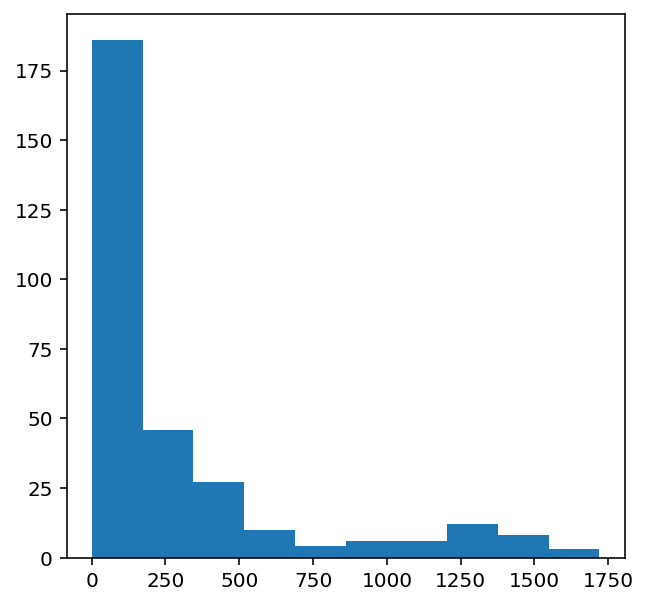

In [6]:
from collections import Counter

freq = dict(Counter(notes_))

import matplotlib.pyplot as plt

no=[count for _,count in freq.items()]

plt.figure(figsize=(5,5))

plt.hist(no)

In [7]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

173


In [9]:
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music,dtype=object)

# Input and Output sequences

Creating input and output sequences where each step of input has first 100 notes and the output has the remaining notes

In [10]:
no_of_timesteps = 50
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):

        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

Neural networks work better with integers, so we can write a function which creates a dictionary which maps each note into an integer and then generate sequences which are the inputs and outputs of the model.

In [11]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

preparing input sequences compatible with neural networks

In [12]:

x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

preparing output sequences compatible with neural networks

In [13]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

Neural Network model creation and splitting of data to feed into the model

In [14]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

# Wavenet Model

In [15]:
from keras.layers import (Dense,
                            Flatten,Conv1D,Embedding,MaxPool1D,Dropout,GlobalMaxPool1D)
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
 
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           17300     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [16]:
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1)


Epoch 1/50
500/500 [==============================] - 61s 122ms/step - loss: 4.3100 - acc: 0.0591 - val_loss: 4.0429 - val_acc: 0.0941
Epoch 2/50
500/500 [==============================] - 70s 141ms/step - loss: 3.8362 - acc: 0.1069 - val_loss: 3.8696 - val_acc: 0.1185
Epoch 3/50
500/500 [==============================] - 71s 143ms/step - loss: 3.6650 - acc: 0.1282 - val_loss: 3.7368 - val_acc: 0.1413
Epoch 4/50
500/500 [==============================] - 64s 127ms/step - loss: 3.5303 - acc: 0.1438 - val_loss: 3.6300 - val_acc: 0.1486
Epoch 5/50
500/500 [==============================] - 71s 142ms/step - loss: 3.4278 - acc: 0.1548 - val_loss: 3.5439 - val_acc: 0.1606
Epoch 6/50
500/500 [==============================] - 67s 134ms/step - loss: 3.3414 - acc: 0.1646 - val_loss: 3.4620 - val_acc: 0.1634
Epoch 7/50
500/500 [==============================] - 68s 136ms/step - loss: 3.2643 - acc: 0.1757 - val_loss: 3.4526 - val_acc: 0.1699
Epoch 8/50
500/500 [==============================] - 7

## Predictions

To generate new samples, we select a random array of sample values as a starting point to model and when the model outputs the probability distribution over all the samples, we choose the value with the maximum probability and append it to an array of samples.We then delete the first element and pass as an input for the next iteration.

In [17]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[81, 75, 17, 17, 75, 17, 28, 17, 17, 28]


In [18]:
random_music

array([ 42, 114,   3,  81,  67,  63,  81, 101, 101, 166,  81, 101,  17,
        17, 101,  17,  28,  28,  17,  28,  47,  47,  28,  47,  42, 114,
         3, 171, 166,  66,  66,  63, 158, 105,  63,  81,  81,  49,  63,
        81,  81,  75,  17,  17,  75,  17,  28,  17,  17,  28])

In [19]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

Next, we will loop through the predicted output and treat chords and notes separately. 

In [20]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='musics.mid')

In [21]:
convert_to_midi(predicted_notes)